This uses ChemCam cleaned, calibrated spectra from the PDS repository. The data is given in csv format with the first column being the wavelength and the following columns representing the intensities measured in units of photons per channels for each of the $n$ shots.

In [1]:
import pandas as pd
from pathlib import Path

def get_first_sample(data_dict: dict[str, list[pd.DataFrame]]):
    v = list(data_dict.keys())[0]
    return (v, data_dict[v])

In [2]:
from PLS_SM.data import load_data

sample_data = load_data("data/data/calib/calib_2015/1600mm/pls/", 10)

In [3]:
get_first_sample(sample_data)[1][0].head()

,wave,shot_avg
0,240.81100,6.185048e+15
1,240.86501,2.362390e+12
2,240.91800,2.487841e+11
3,240.97200,7.561940e+11
4,241.02699,1.387382e+12


In [4]:
from PLS_SM.data import WavelengthMaskTransformer, transform_samples
from PLS_SM.reproduction import masks

masked_samples = transform_samples(sample_data, WavelengthMaskTransformer(masks))

get_first_sample(masked_samples)[1][0].head()

,wave,shot_avg
110,246.68800,3.998589e+11
111,246.74100,3.623102e+11
112,246.79401,3.125834e+11
113,246.84700,2.548143e+11
114,246.89999,2.384109e+11


> The spectra from the first five shots are discarded to minimize any surface contamination, and the subsequent 45 shots from each location are averaged together to give 5 spectra per sample (2040 spectra total).

The reason there are 5 *.csv files for each sample is that they shot at 5 different locations for each sample.
The first 5 shots are discarded to minimize any surface contamination, and the subsequent 45 shots from each location are averaged together to give 5 spectra per sample (2040 spectra total).

# Plotting

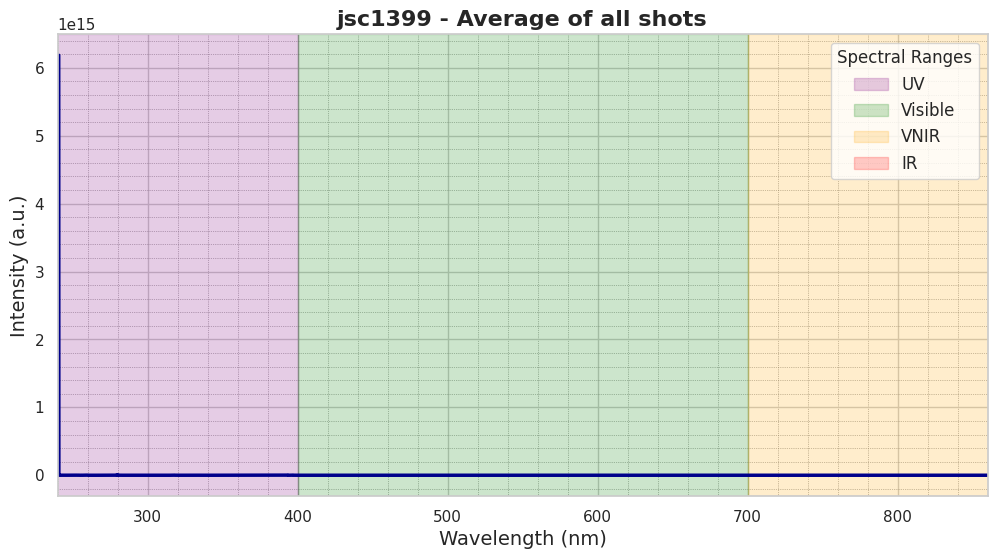

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sample(sample_name, sample):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    sns.lineplot(x=sample["wave"], y=sample["shot_avg"], linewidth=2.5, linestyle='-', color='darkblue')

    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

    ranges = {
        'UV': (100, 400, 'purple'),
        'Visible': (400, 700, 'green'),
        'VNIR': (700, 1100, 'orange'),
        'IR': (1100, 2500, 'red')
    }

    for label, (start, end, color) in ranges.items():
        plt.axvspan(start, end, alpha=0.2, label=label, color=color)

    plt.title(f"{sample_name} - Average of all shots", fontsize=16, fontweight='bold')
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Intensity (a.u.)", fontsize=14) # a.u. = arbitrary units
    plt.legend(title='Spectral Ranges', loc='upper right', fontsize=12)
    plt.xlim(240, 860)
    plt.show()

name, samples = get_first_sample(sample_data)
plot_sample(name, samples[0])

# Check difference between ICA & PLS folders

In [6]:
ica = Path("data/data/calib/calib_2015/1600mm/ica/")
pls = Path("data/data/calib/calib_2015/1600mm/pls/")

def get_samples(path):
    return set(map(lambda p: p.name, list(path.glob("*"))))

ica_samples = get_samples(ica)
pls_samples = get_samples(pls)

# samples that are in both pls and ica
print(set(ica_samples) & set(pls_samples))

# samples that are in pls but not in ica
print(set(pls_samples) - set(ica_samples))

# samples that are in ica but not in pls
print(set(ica_samples) - set(pls_samples))

{'gypb', 'jsc1463', 'dkm2390', 'jb3', 'jsc1460', '34p4', 'gbw07217a', 'bir1a', 'g25mt', 'r21', 'jsc1424', 'trond', 'jsc1445', 'moppin', 'dh4912', 'gbw07104', 'dkm1590', 'p12mt', 'sc4', 'g10mt', 'g13mt', '221136', 'r44', 'dkm3290', 'sanci', 'sarm17', 'dkm1790', 'r62', 'jsc1381', 'jsc1436', 'wc3', '152769', 'jsc1448', 'norite', 'hvalfj011', 'pl3', 'gl3mt', 'jsc1462', 'g27mt', 'cadillac', 'jsc1464', 'idbdf', 'jsc1404', 'mhc3828', 'jsc1444', 'g6mt', 'gl2mt', 'jsc1386', 'dkm2990', 'bwqc1', 'jsc1459', 'ao7', 'nat18', 'jsc1433', 'mc', 'ps4', 'jsc1419', 'jsc1382', 'jsc1391', 'jsc1383', 'jsc1455', 'r24', 'dh4909', 'jsc1373', 'jsc1396', '10tio2', 'sc1', 'jsc1411', 'p10mt', 'mix4o', '5tio2', 'm4mt', 'sanck', 'shergottite', 'jsc1461', 'p11mt', '132', 'gbw07315', '8005', 'dkm390', 'pl1b', 'unszk', 'dh4911', 'ja1', 'jsc1374', 'g20mt', 'mix2b', 'jsc1413', 'jsc1365', 'jsc1420', '81', 'dkm2290', 'r61', 'pw6', 'jsc1405', 'mix6b', 'jsc1407', 'lp14', 'gl6mt', 'gypa', 'p8mt', 'mix1b', 'm8mt', 'gl1mt', 'uns

# Training

- Train full model to get predictions for all samples for all oxides
- Train 3 sub-models for each oxide

In [1]:
from PLS_SM.data import CustomSpectralPipeline, load_data
from PLS_SM.reproduction import masks, major_oxides

pipeline = CustomSpectralPipeline(
    intensity_feature_name="shot_avg",
    wavelength_feature_name="wave",
    masks=masks,
    major_oxides=major_oxides,
    composition_data_loc="data/data/calib/ccam_calibration_compositions.csv"
)

new_sample_data = load_data("data/data/calib/calib_2015/1600mm/pls/", 10)

transformed_samples = pipeline.fit_transform(new_sample_data)
transformed_samples

,246.688,246.741,246.79401,246.847,246.89999,246.953,247.007,247.06,247.11301,247.166,...,SiO2,TiO2,Al2O3,FeOT,MnO,MgO,CaO,Na2O,K2O,Sample Name
0,3.998589e+11,3.623102e+11,3.125834e+11,2.548143e+11,2.384109e+11,2.535727e+11,2.867055e+11,3.181519e+11,3.228308e+11,3.108220e+11,...,51.03,1,13.830000,9.930000,0.175000,6.33,10.700000,2.01,0.6,jsc1399
1,3.101115e+11,2.760840e+11,2.294153e+11,1.789714e+11,1.602546e+11,1.737365e+11,2.033433e+11,2.307903e+11,2.380900e+11,2.286484e+11,...,51.03,1,13.830000,9.930000,0.175000,6.33,10.700000,2.01,0.6,jsc1399
2,4.784395e+11,4.364859e+11,3.787261e+11,3.007351e+11,2.869929e+11,3.060502e+11,3.437366e+11,3.862550e+11,3.896103e+11,3.750934e+11,...,51.03,1,13.830000,9.930000,0.175000,6.33,10.700000,2.01,0.6,jsc1399
3,5.402266e+11,4.974165e+11,4.266432e+11,3.354670e+11,3.232402e+11,3.433198e+11,3.847175e+11,4.298031e+11,4.313859e+11,4.173089e+11,...,51.03,1,13.830000,9.930000,0.175000,6.33,10.700000,2.01,0.6,jsc1399
4,4.925927e+11,4.457917e+11,3.862441e+11,3.063318e+11,2.987273e+11,3.191648e+11,3.567172e+11,3.909940e+11,3.978301e+11,3.836622e+11,...,51.03,1,13.830000,9.930000,0.175000,6.33,10.700000,2.01,0.6,jsc1399
5,7.224237e+11,6.645602e+11,5.624923e+11,4.217554e+11,4.086364e+11,4.559630e+11,5.132172e+11,5.743058e+11,5.769901e+11,5.580480e+11,...,52.18985755,2.969163409,16.328663,13.221575,0.194498,5.766648112,11.709642,2.895858639,0.60510479,jsc1469
6,6.043420e+11,5.457742e+11,4.529787e+11,3.235007e+11,3.031626e+11,3.494422e+11,4.060864e+11,4.653911e+11,4.659955e+11,4.438727e+11,...,52.18985755,2.969163409,16.328663,13.221575,0.194498,5.766648112,11.709642,2.895858639,0.60510479,jsc1469
7,7.273928e+11,6.712359e+11,5.744415e+11,4.306283e+11,4.213495e+11,4.595690e+11,5.141930e+11,5.765110e+11,5.825250e+11,5.602250e+11,...,52.18985755,2.969163409,16.328663,13.221575,0.194498,5.766648112,11.709642,2.895858639,0.60510479,jsc1469
8,1.071617e+12,9.870790e+11,8.088976e+11,5.703765e+11,5.372312e+11,6.240876e+11,7.244892e+11,8.460035e+11,8.346761e+11,7.912939e+11,...,52.18985755,2.969163409,16.328663,13.221575,0.194498,5.766648112,11.709642,2.895858639,0.60510479,jsc1469
9,7.429635e+11,6.745234e+11,5.772690e+11,4.443604e+11,4.271427e+11,4.690403e+11,5.273304e+11,5.834271e+11,5.883482e+11,5.697515e+11,...,52.18985755,2.969163409,16.328663,13.221575,0.194498,5.766648112,11.709642,2.895858639,0.60510479,jsc1469


In [4]:
from numpy import sqrt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

for oxide in major_oxides:
    X = transformed_samples.drop(major_oxides, axis=1)
    y = transformed_samples[oxide]

    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    pls = PLSRegression(n_components=2)
    pls.fit(X_train, y_train)

    # Make predictions
    y_pred_train = pls.predict(X_train)
    y_pred_test = pls.predict(X_test)

    # Evaluate the model
    mse_train = sqrt(mean_squared_error(y_train, y_pred_train))
    mse_test = sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"Train RMSE: {mse_train}, Test RMSE: {mse_test}")
    break

Train RMSE: 1.4902680659394107, Test RMSE: 7.582845463305751
